In [69]:
import sys; sys.path.append('..'); from wwa import *

fpath = "../../00_WWA_project_folder/ephemeral/Phillippines_wwa/"

xn, xx, yn, yx = [125, 127, 5, 10]

sf = gpd.read_file("sf_philippines")

In [204]:
def rxnday(ds, n = 5):
    
    ts = xr.open_dataset(fpath+"obs/"+ds+"_daily.nc")
    ts = ts[list(ts.data_vars)[0]].rename("pr")
    
    ts = ts.rolling(time = n).sum().resample(time = "QS-DEC").max().groupby("time.season")["DJF"]
    ts = ts.assign_coords(time = ts.time.dt.year).rename("year")
    
    return ts

# Extract time series from other gridded obs

In [ ]:
for fnm in glob.glob("../../00_WWA_project_folder/live/data/chirps_05/*.nc"):
    ds = xr.open_dataset(fnm).sel(longitude = slice(xn,xx), latitude = slice(yn,yx))
    ds.to_netcdf(fpath+"obs/"+fnm.split("/")[-1])

chirps = xr.open_mfdataset(fpath+"obs/chirps*.nc").precip

chirps_rm = regionmask.mask_3D_geopandas(sf, chirps.longitude, chirps.latitude).squeeze(drop = True)
chirps_ts = chirps.where(chirps_rm == 1).mean(["latitude", "longitude"]).load()
chirps_ts.to_netcdf(fpath+"obs/chirps_daily.nc")

In [210]:
rxnday("chirps", 5).to_dataframe().to_csv(fpath+"chirps-rx5day.csv")

In [110]:
era5 = xr.open_dataset("era5_tp_daily_125-127E_5-10N_su.nc").tp

era5_rm = regionmask.mask_3D_geopandas(sf, era5.lon, era5.lat).squeeze(drop = True)
era5_ts = era5.where(era5_rm == 1).mean(["lat", "lon"]).load()
era5_ts.to_netcdf(fpath+"obs/era5_daily.nc")

In [134]:
for fnm in glob.glob("../../00_WWA_project_folder/live/data/cpc/precip.*.nc"):
    ds = wrap_lon(xr.open_dataset(fnm)).sel(lon = slice(xn,xx), lat = slice(yn,yx))
    ds.to_netcdf(fpath+"obs/"+fnm.split("/")[-1])

cpc = xr.open_mfdataset(fpath+"obs/precip.*.nc").precip

cpc_rm = regionmask.mask_3D_geopandas(sf, cpc.lon, cpc.lat).squeeze(drop = True)
cpc_ts = cpc.where(cpc_rm == 1).mean(["lat", "lon"]).load()
cpc_ts.to_netcdf(fpath+"obs/cpc_daily.nc")

# Trend checking


## Compare obs

In [195]:
fig, axs = plt.subplots(ncols = 2, figsize = (10,3), dpi = 100)

for i in range(2):
    n = [1,5][i]
    ax = axs[i]
    
    rx = xr.concat([rxnday(ds, n).expand_dims(source = [ds]) for ds in ["mswep", "chirps", "era5", "cpc"]], "source").transpose().to_pandas()
    rx.plot(ax = ax, drawstyle = "steps")
    ax.set_title("rx"+str(n)+"day")

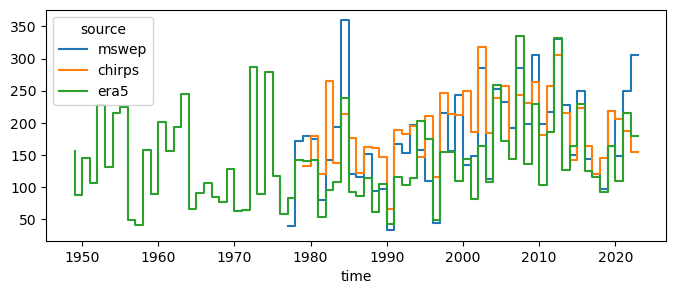

In [218]:
fig, axs = plt.subplots(ncols = 1, figsize = (8,3), dpi = 100)
n = 5
rx = xr.concat([rxnday(ds, n).expand_dims(source = [ds]) for ds in ["mswep", "chirps", "era5"]], "source").transpose().to_pandas()
rx.plot(ax = axs, drawstyle = "steps")
ax.set_title("rx"+str(n)+"day")

plt.savefig("fig/obs_rx5day_timeseries.png")

## Assumption of constant dispersion

## Observations

Text(0.5, 1.02, 'Mean, SD & dispersion in rx1day')

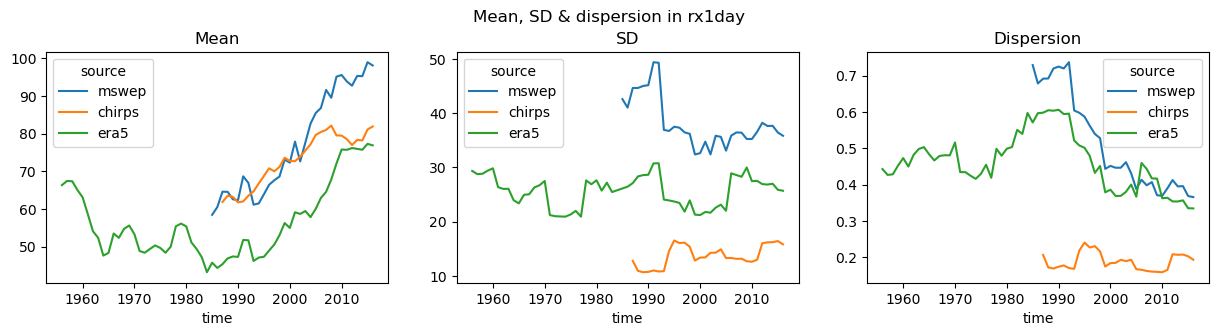

In [211]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,3), dpi = 100)

ts = xr.concat([rxnday(ds, 1).expand_dims(source = [ds]) for ds in ["mswep", "chirps", "era5"]], "source").transpose().to_pandas()

ts.rolling(15, center = True).mean().plot(ax = axs[0])
axs[0].set_title("Mean")

ts.rolling(15, center = True).std().plot(ax = axs[1])
axs[1].set_title("SD")

(ts.rolling(15, center = True).std() / ts.rolling(15, center = True).mean()).plot(ax = axs[2])
axs[2].set_title("Dispersion")

plt.suptitle("Mean, SD & dispersion in rx1day", y = 1.02)


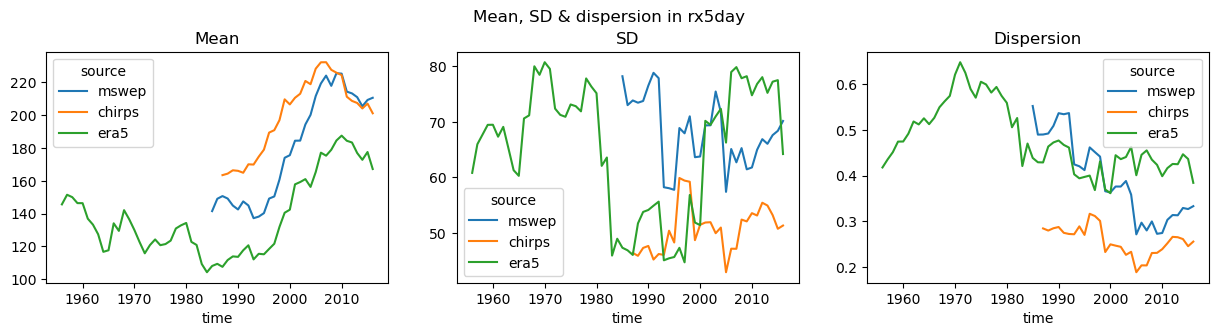

In [212]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,3), dpi = 100)

ts = xr.concat([rxnday(ds, 5).expand_dims(source = [ds]) for ds in ["mswep", "chirps", "era5"]], "source").transpose().to_pandas()

ts.rolling(15, center = True).mean().plot(ax = axs[0])
axs[0].set_title("Mean")

ts.rolling(15, center = True).std().plot(ax = axs[1])
axs[1].set_title("SD")

(ts.rolling(15, center = True).std() / ts.rolling(15, center = True).mean()).plot(ax = axs[2])
axs[2].set_title("Dispersion")

plt.suptitle("Mean, SD & dispersion in rx5day", y = 1.02)

plt.savefig("fig/obs_rx5day_dispersion.png")

### CORDEX

Text(0.5, 1.0, 'Dispersion')

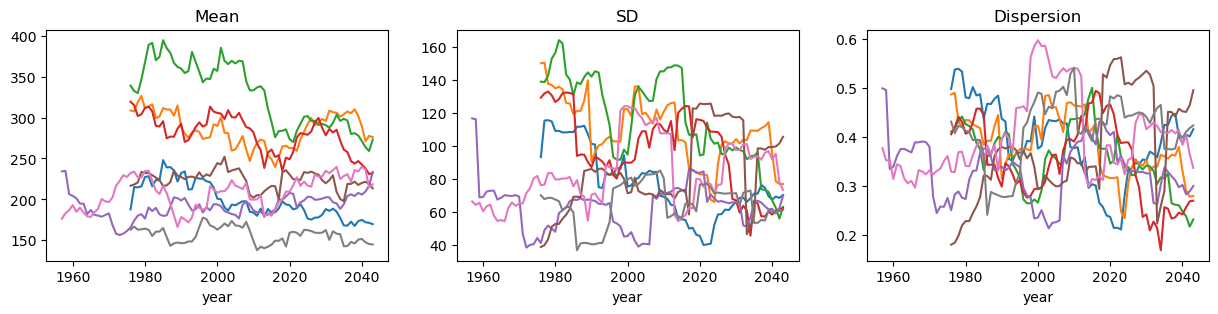

In [121]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,3), dpi = 100)
for fnm in glob.glob(fpath+"ts/*.dat"):
    df = pd.read_csv(fnm, sep = " ", comment = "#", names = ["year", "pr"], index_col = "year")
    df.pr.rolling(15, center = True).mean().plot(ax = axs[0])
    df.pr.rolling(15, center = True).std().plot(ax = axs[1])
    (df.pr.rolling(15, center = True).std() / df.pr.rolling(15, center = True).mean()).plot(ax = axs[2])
    
axs[0].set_title("Mean")
axs[1].set_title("SD")
axs[2].set_title("Dispersion")

Text(0.5, 1.0, 'Dispersion')

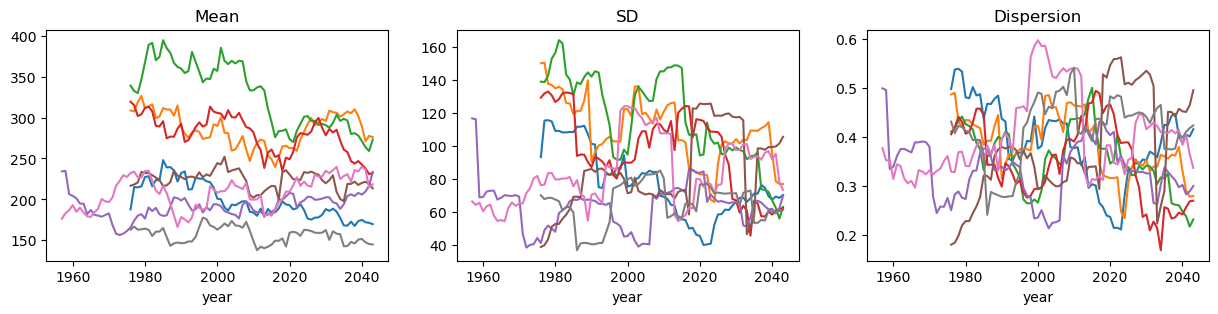

In [122]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,3), dpi = 100)
for fnm in glob.glob(fpath+"ts/*.dat"):
    df = pd.read_csv(fnm, sep = " ", comment = "#", names = ["year", "pr"], index_col = "year")
    df.pr.rolling(15, center = True).mean().plot(ax = axs[0])
    df.pr.rolling(15, center = True).std().plot(ax = axs[1])
    (df.pr.rolling(15, center = True).std() / df.pr.rolling(15, center = True).mean()).plot(ax = axs[2])
    
axs[0].set_title("Mean")
axs[1].set_title("SD")
axs[2].set_title("Dispersion")

### CORDEX

Text(0.5, 1.0, 'Dispersion')

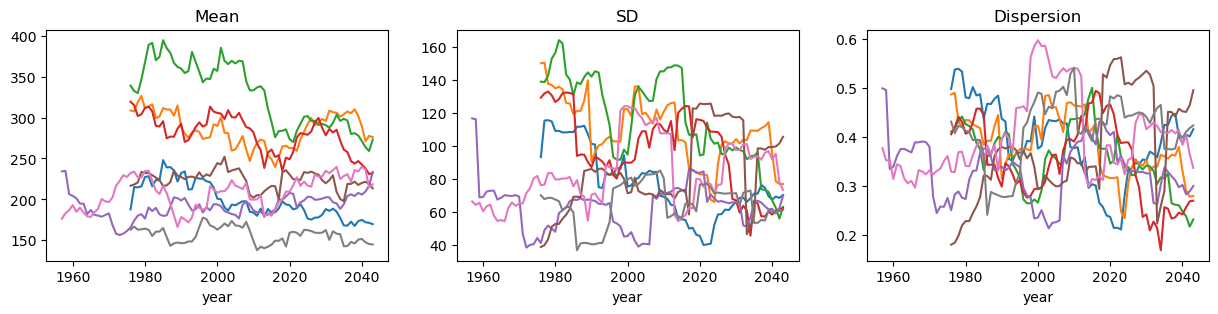

In [43]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,3), dpi = 100)
for fnm in glob.glob(fpath+"ts/*.dat"):
    df = pd.read_csv(fnm, sep = " ", comment = "#", names = ["year", "pr"], index_col = "year")
    df.pr.rolling(15, center = True).mean().plot(ax = axs[0])
    df.pr.rolling(15, center = True).std().plot(ax = axs[1])
    (df.pr.rolling(15, center = True).std() / df.pr.rolling(15, center = True).mean()).plot(ax = axs[2])
    
axs[0].set_title("Mean")
axs[1].set_title("SD")
axs[2].set_title("Dispersion")

### HighResMIP

Text(0.5, 1.0, 'Dispersion')

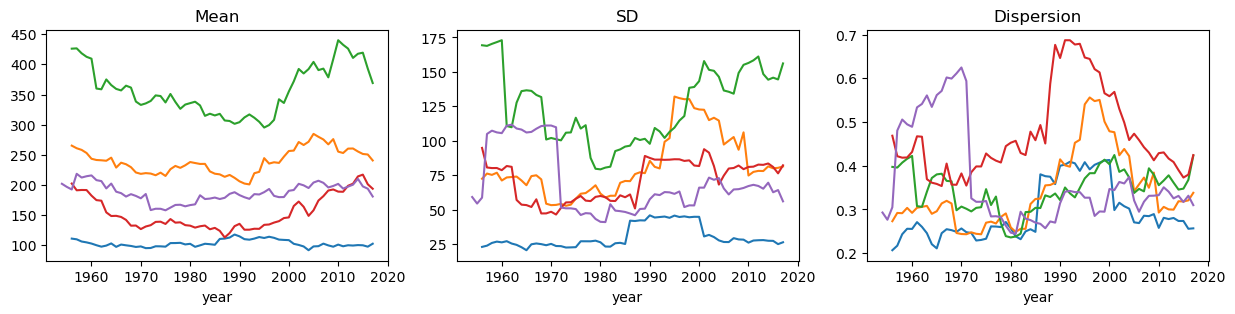

In [123]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,3), dpi = 100)
for fnm in glob.glob(fpath+"hiresmip-ts/*.dat"):
    df = pd.read_csv(fnm, sep = " ", comment = "#", names = ["year", "pr"], index_col = "year")
    df.pr.rolling(15, center = True).mean().plot(ax = axs[0])
    df.pr.rolling(15, center = True).std().plot(ax = axs[1])
    (df.pr.rolling(15, center = True).std() / df.pr.rolling(15, center = True).mean()).plot(ax = axs[2])
    
axs[0].set_title("Mean")
axs[1].set_title("SD")
axs[2].set_title("Dispersion")